<h2>1 次元反強磁性ハイゼンベルグモデルの制限ボルツマンマシンによる解法<br>
&ensp;&ensp;&ensp;(確率的再配置法による最適化)</h2>
<div>　</div>
<div>制限ボルツマンマシン : Ristricted Boltzmann Machine(RBM)</div>
<div>確率的再配置法 : stochastic reconfiguration(SR)</div>   

<div>変数リスト</div>
<table border="1">
    <tr>
        <th>変数名</th>
        <th>内容</th>
    </tr>
    <tr>
        <td>L</td>
        <td>system size</td>
    </tr>
    <tr>
        <td>D</td>
        <td>dimension of hilbert space</td>
    </tr>
    <tr>
        <td>alpha</td>
        <td>hidden varible density $\alpha$</td>
    </tr>
    <tr>
        <td>N</td>
        <td>number of visible units $N = L$</td>
    </tr>
    <tr>
        <td>M</td>
        <td>number of hidden units $M = \alpha L$</td>
    </tr>
    <tr>
        <td>Nv</td>
        <td>number of variational parameters $N_v = \alpha N$</td>
    </tr>
    <tr>
        <td>Nstep</td>
        <td>total number of optimization steps</td>
    </tr>
    <tr>
        <td>delta_tau</td>
        <td>controls the amount of parameter update</td>
    </tr>
    <tr>
        <td>f</td>
        <td>index for independent neurons</td>
    </tr>
    <tr>
        <td>i</td>
        <td>index for visible units</td>
    </tr>
    <tr>
        <td>j</td>
        <td>index for hidden units</td>
    </tr>
    <tr>
        <td>k</td>
        <td>index for variational parameters</td>
    </tr>
    <tr>
        <td>jj</td>
        <td>subindex for hidden units</td>
    </tr>
    <tr>
        <td>ix</td>
        <td>index for Fock states</td>
    </tr>
    <tr>
        <td>iw</td>
        <td>index for W interaction</td>
    </tr>
    <tr>
        <td>iteration</td>
        <td>index for optimization iterations</td>
    </tr>
    <tr>
        <td>psi_x</td>
        <td>$\psi(x) = <x|\psi>$</td>
    </tr>
    <tr>
        <td>psi_xp</td>
        <td>$\psi(x') = <x'|\psi>$</td>
    </tr>
    <tr>
        <td>norm</td>
        <td>$<\psi(x)|\psi(x)>$</td>
    </tr>
    <tr>
        <td>p_x</td>
        <td>$|\psi(x)|^2$</td>
    </tr>
    <tr>
        <td>Eloc_x</td>
        <td>$\sum_{x'}<x|H|x'>\dfrac{\psi(x')}{\psi(x)}$</td>
    </tr>
    <tr>
        <td>E</td>
        <td>total energy</td>
    </tr>
    <tr>
        <td>delW_max</td>
        <td>maximum changes in W at<br> each optimization step</td>
    </tr>
    <tr>
        <td>xlist</td>
        <td>list of Fock states</td>
    </tr>
    <tr>
        <td>x</td>
        <td>Fock states $|x> = |\sigma_1, \sigma_2, ... , \sigma_N>$</td>
    </tr>
    <tr>
        <td>xp</td>
        <td>Fock states $|x'> = |\sigma'_1, \sigma'_2, ... , \sigma'_N>$</td>
    </tr>
    <tr>
        <td>theata</td>
        <td>$\theta_j = \sum_iW_{ij}\sigma_i$</td>
    </tr>
    <tr>
        <td>theatap</td>
        <td>$\theta'_j = \sum_iW_{ij}\sigma'_i$</td>
    </tr>
    <tr>
        <td>gvec</td>
        <td>derivative of energy with repect to variational<br>
            $g = \dfrac{\partial E}{\partial \alpha_k}$</td>
    </tr>
    <tr>
        <td>Ovec_loc_x</td>
        <td>$\dfrac{\partial}{\partial \alpha_k}\mathrm{ln}(\psi_\alpha(x))$</td>
    </tr>
    <tr>
        <td>Ovec</td>
        <td>$<\mathcal{O}_k> = \sum_x |\psi(x)|^2 \dfrac{\partial}{\partial \alpha_k}\mathrm{ln}(\psi_\alpha(x))$</td>
    </tr>
    <tr>
        <td>Smat</td>
        <td>metric</td>
    </tr>
</table>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
import time

In [2]:
# theta の計算
def calc_theta(sigma, Wirr) :
    theta = np.zeros((M))
    W = np.zeros((N, M))
    j = 0
    for f in range(alpha) :
        for jj in range(N) :
            for i in range(N) :
                iw = i - jj
                if iw < 0 :
                    iw = iw + N
                W[i][j] = Wirr[iw][f]
                theta[j] = theta[j] + W[i][j]*sigma[i]
            j += 1

    return theta

# RBM 波動関数の計算
def calc_amplitude_RBM(M, theta) :
    psi_x = 1.0
    for j in range(M) :
        psi_x = psi_x * np.cosh(theta[j])
    return psi_x

# 同じものを含む順列の生成
def permutations(iterable, permutation=[]):
    if not iterable:
        yield permutation
        pass
    for i in [iterable.index(i) for i in set(iterable)]:
        yield from permutations(iterable[:i] + iterable[i+1:], permutation + [iterable[i]])

<h2>条件設定と Fock state の作成

In [3]:
# 条件設定
L = 8
alpha = 1
Nstep = 3000
delta_tau = 0.0001

N = L
M = alpha * N
Nv = alpha * N

# Fock state list の作成
spin = [1,1,1,1,-1,-1,-1,-1]  # N = 8
#spin = [1,1,1,1,1,-1,-1,-1,-1,-1]  # N = 10
#spin = [1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1]  # N = 16
xlist = []
for i in permutations(spin):
    xlist.append(i)
xlist = np.array(xlist)

D = len(xlist) # Hilbert 空間の次元

## 変分パラメータ W の初期化

In [4]:
Wirr = np.zeros((N, alpha))

np.random.seed(seed = 1000)

for f in range(alpha) :
    for iw in range(N) :
        Wirr[iw][f] = 0.02*(np.random.rand()-0.5)

## 波動関数 $\psi(x)$ の初期化

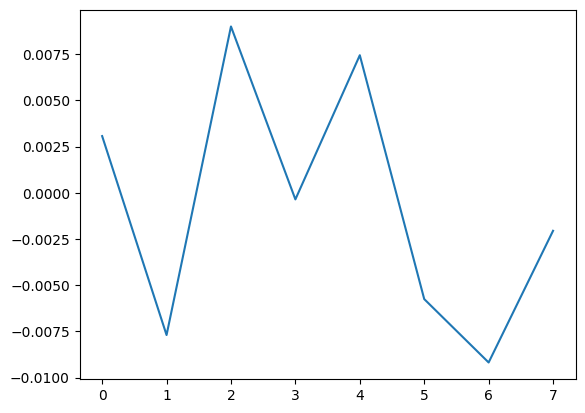

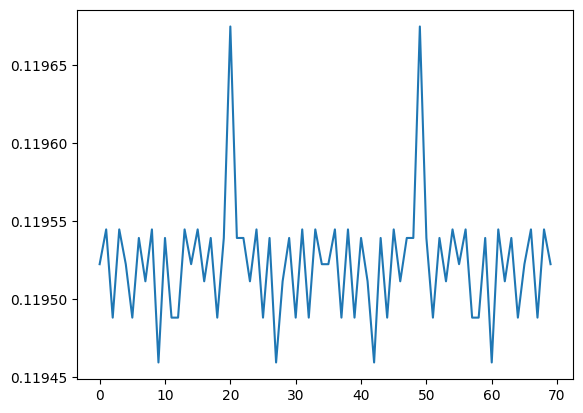

In [6]:
psi = np.zeros((D))
norm = 0

for ix in range(D) :
    theta = calc_theta(xlist[ix], Wirr)
    psi[ix] = calc_amplitude_RBM(M, theta)
    norm += psi[ix]*psi[ix]

Wirr_ini = copy.deepcopy(Wirr)
psi_ini = copy.deepcopy(psi/np.sqrt(norm))

plt.plot([Wirr[i][0] for i in range(8)])
plt.show()
plt.plot(psi/np.sqrt(norm))
plt.show()

## RBM による学習（最適化）

In [7]:
startTime = time.time()

for iteration in range(Nstep) :

    norm = 0
    E = 0
    gvec = np.zeros((Nv))
    Ovec = np.zeros((Nv))
    Ovec_loc_x = np.zeros((Nv))
    Smat = np.zeros((Nv, Nv))

    for ix in range(D) :
        x = copy.deepcopy(xlist[ix])
        theta = calc_theta(x, Wirr)
        psi_x = calc_amplitude_RBM(M, theta)
        p_x = psi_x*psi_x
        norm += p_x

        Eloc_x = 0.0
        for i1 in range(N) :
            i2 = i1 + 1
            if(i1 == N - 1) :
                i2 = 0
            Eloc_x += x[i1]*x[i2]

            if x[i1] != x[i2] :
                xp = copy.deepcopy(x)
                xp[i1] = -xp[i1]
                xp[i2] = -xp[i2]
                thetap = calc_theta(xp, Wirr)
                psi_xp = calc_amplitude_RBM(M, thetap)
                Eloc_x += -2.0*psi_xp/psi_x

        E += p_x*Eloc_x

        k = 0
        for f in range(alpha) :
            for iw in range(N) :
                Ovec_loc_x[k] = 0.0
                for jj in range(N) :
                    j = (f-1)*N + jj
                    i = jj + iw
                    if i > N - 1 :
                        i += -N
                    Ovec_loc_x[k] += np.tanh(theta[j])*x[i]
                k += 1

        if k != Nv :
            print("Error")

        for k in range(Nv) :
            gvec[k] += 2.0*p_x*Eloc_x*Ovec_loc_x[k]
            Ovec[k] += p_x*Ovec_loc_x[k]

        for k2 in range(Nv) :
            for k1 in range(Nv) :
                Smat[k1][k2] += p_x*Ovec_loc_x[k1]*Ovec_loc_x[k2]

    gvec = gvec/norm
    Ovec = Ovec/norm
    E = E/norm
    Smat = Smat/norm

    for k in range(Nv) :
        gvec[k] += -2.0*E*Ovec[k]

    Sdiag_min = 1000000000.0
    for k2 in range(Nv) :
        for k1 in range(Nv) :
            Smat[k1][k2] += -Ovec[k1]*Ovec[k2]
            if k1 == k2 :
                if Smat[k1][k2] <= 0.0 :
                    print('diagonal element of S matrix is not positive')
                if Sdiag_min > Smat[k1][k2] :
                    Sdiag_min = Smat[k1][k2]

    for k1 in range(Nv) :
        Smat[k1][k1] += Sdiag_min*0.001

    gvec = np.linalg.solve(Smat, gvec)

    delW_max = 0.0
    for k in range(Nv) :
        if np.abs(delta_tau*gvec[k]) > delW_max :
            delW_max = np.abs(delta_tau*gvec[k])

    k = 0
    for f in range(alpha) :
        for iw in range(N) :
            if delW_max > 0.003 :
                Wirr[iw][f] += -delta_tau*gvec[k]*(0.003/delW_max)
            else :
                Wirr[iw][f] += -delta_tau*gvec[k]
            k += 1

    if (iteration + 1) % 20 == 0 :
        sys.stdout.write("\riteration : {0}, total energy: {1:.6f}, dW_max : {2:.6f}".format(iteration + 1, E, min(delW_max, 0.003)))
        sys.stdout.flush()
#         print("iteration : {0}, total energy: {1:.6f}, dW_max : {2:.6f}".format(iteration, E, min(delW_max, 0.003)))
print(" ")
print("execution time : {0:.3f}sec".format(time.time() - startTime))

iteration : 3000, total energy: -14.603878, dW_max : 0.000030 
execution time : 240.017sec


## 結果表示
### 基底状態のエネルギー、波動関数 $\psi(x)$ 、変分パラメータ $W_{ij}$

Ground State Energy : -14.603877541916896


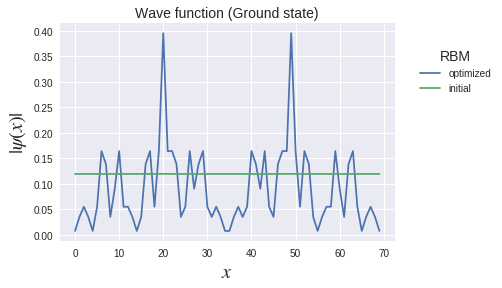

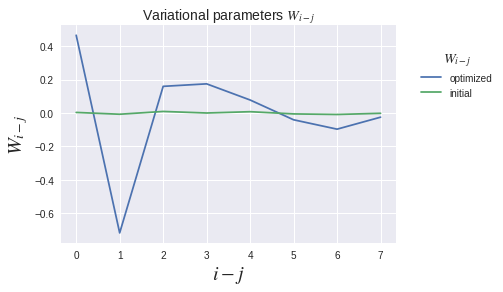

In [ ]:
print("Ground State Energy :", E)

psi = np.zeros((D))
norm = 0

for ix in range(D) :
    theta = calc_theta(xlist[ix], Wirr)
    psi[ix] = calc_amplitude_RBM(M, theta)
    norm += psi[ix]*psi[ix]

# グラフの設定
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 14

# 基底状態の波動関数の表示
plt.title("Wave function (Ground state)", fontsize = 14)
plt.xlabel(r'$x$', fontsize=20)
plt.ylabel(r'$|\psi (x)|$', fontsize=20)
plt.plot(psi/np.sqrt(norm), label="optimized")
plt.plot(psi_ini, label="initial")
plt.legend(loc='upper right',
           bbox_to_anchor=(0.8, 0.8, 0.5, 0.1),
           borderaxespad=0.,
           title="RBM")
plt.show()

plt.title(r"Variational parameters $W_{i-j}$", fontsize = 14)
plt.xlabel(r'$i-j$', fontsize=20)
plt.ylabel(r'$W_{i-j}$', fontsize=20)
plt.plot([Wirr[i][0] for i in range(L)], label="optimized")
plt.plot([Wirr_ini[i][0] for i in range(L)], label="initial")
plt.legend(loc='upper right',
           bbox_to_anchor=(0.8, 0.8, 0.5, 0.1),
           borderaxespad=0.,
           title=r"$W_{i-j}$")
plt.show()